In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal as sig
from scipy import stats as stat
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy import fft
import importlib

import processing_helpers as ph
from processing_helpers import do_linear_regression
from processing_helpers import get_residuals
from processing_helpers import segment_data

In [2]:
importlib.reload(ph)

<module 'processing_helpers' from '/Users/crfosse/master/dt_data/processing_helpers.py'>

In [3]:
#initial constants
delta_t = 0.00025

#voltage
V = 3.7

to_uWh = (1000*1000*delta_t*V)/3600

nb_active_energy = 28.48 #uWh Based on 20 measurements from test data
nb_active_time = 20.48

ltem_active_energy = 101.95 #uWh Based on 20 measurements from test data
ltem_active_time = 10.24

In [4]:
##CoAP 
coap_byte_step = 41

sweep_file1 = "../measurements/otii/sweep_coap_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_coap_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_coap_psm_test03.csv" 


coap_nb_data = []
coap_nb_data.append(pd.read_csv(sweep_file1))
coap_nb_data.append(pd.read_csv(sweep_file2))
coap_nb_data.append(pd.read_csv(sweep_file3))


sweep_file1 = "../measurements/otii/sweep_ltem_coap_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_ltem_coap_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_ltem_coap_psm_test03.csv"
sweep_file4 = "../measurements/otii/sweep_ltem_coap_psm_test04.csv"


coap_ltem_data = []
coap_ltem_data.append(pd.read_csv(sweep_file1))
coap_ltem_data.append(pd.read_csv(sweep_file2))
coap_ltem_data.append(pd.read_csv(sweep_file3))
coap_ltem_data.append(pd.read_csv(sweep_file4))


In [5]:
##MQTT
mqtt_byte_step = 64

sweep_file1 = "../measurements/otii/sweep_mqtt_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_mqtt_psm_test02.csv" 
sweep_file3 = "../measurements/otii/sweep_mqtt_psm_test03.csv" 


mqtt_data = []
mqtt_data.append(pd.read_csv(sweep_file1))
mqtt_data.append(pd.read_csv(sweep_file2))
mqtt_data.append(pd.read_csv(sweep_file3))

sweep_file1 = "../measurements/otii/sweep_ltem_mqtt_psm_test01.csv"
sweep_file2 = "../measurements/otii/sweep_ltem_mqtt_psm_test02.csv"
sweep_file3 = "../measurements/otii/sweep_ltem_mqtt_psm_test03.csv"

mqtt_ltem_data = []
mqtt_ltem_data.append(pd.read_csv(sweep_file1))
mqtt_ltem_data.append(pd.read_csv(sweep_file2))
#mqtt_ltem_data.append(pd.read_csv(sweep_file3)) #major outlier that affects segmenting



In [6]:
coap_nb_energy = []
coap_nb_current = []
for i in coap_nb_data:
    coap_nb_energy.append(i["Arc Main Energy (J)"])
    coap_nb_current.append(i["Arc Main Current (A)"])

mqtt_nb_energy = []
mqtt_nb_current = []
for i in mqtt_data:
    mqtt_nb_energy.append(i["Arc Main Energy (J)"])
    mqtt_nb_current.append(i["Arc Main Current (A)"])

coap_ltem_energy = []
coap_ltem_current = []
for i in coap_ltem_data:
    coap_ltem_energy.append(i["Arc Main Energy (J)"])
    coap_ltem_current.append(i["Arc Main Current (A)"])

mqtt_ltem_energy = []
mqtt_ltem_current = []
for i in mqtt_ltem_data:
    mqtt_ltem_energy.append(i["Arc Main Energy (J)"])
    mqtt_ltem_current.append(i["Arc Main Current (A)"])

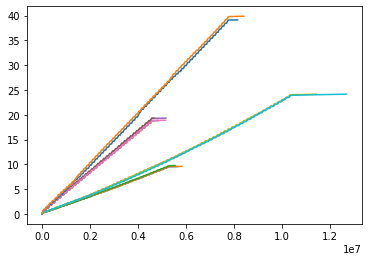

In [7]:
plt.figure()
for i in coap_nb_energy:
    i.plot()

for i in coap_ltem_energy:
    i.plot()

for i in mqtt_nb_energy:
    i.plot()

for i in mqtt_ltem_energy:
    i.plot()   

In [8]:
[segments_coap_nb, timing_coap_nb] = segment_data(coap_nb_current, 160000, 0.01, 120000, 20000)

Batch: 0
Batch: 1
Batch: 2


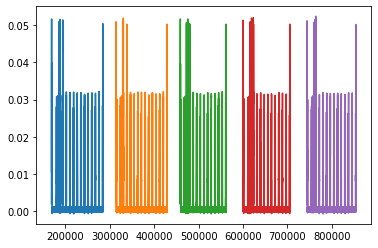

In [9]:
for i in range(0,5):
    segments_coap_nb[0][i].plot()

plt.savefig("segments/coap_nb_segments.png", transparent = True, dpi = 300)

36
36
36


Text(0.5, 0, 'Payload size [Bytes]')

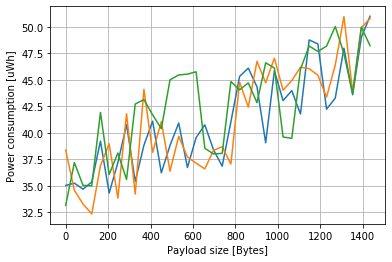

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#coap_nb_sums = np.zeros((len(segments_coap_nb[0]), len(segments_coap_nb)))
coap_nb_sums = []

bytes_coap = range(0,coap_byte_step*len(segments_coap_nb[0]), coap_byte_step)

for i in segments_coap_nb:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - nb_active_energy
        sum_acc.append(curr_sum)
        #coap_nb_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_coap,sum_acc, label = str(idx_seg))
    coap_nb_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [11]:
coap_nb_sums[0][0]+nb_active_energy

63.525345400284706

In [12]:
coap_nb_stds = []
coap_nb_avg = []

for i in range(len(coap_nb_sums[0])):
    curr_sample = []
    for j in range(len(coap_nb_sums)):
        curr_sample.append(coap_nb_sums[j][i])
    coap_nb_avg.append(np.mean(curr_sample))
    coap_nb_stds.append(np.std(curr_sample))
   
print(np.mean(coap_nb_stds))
print(coap_nb_avg[1])

1.8828686059831148
35.68630409885416


In [13]:
segments_coap_ltem = []
timing_coap_ltem = []

[segments_coap_ltem, timing_coap_ltem] = segment_data(coap_ltem_current, 100000, 0.01, 60000, 20000)

Batch: 0
Batch: 1
Batch: 2
Batch: 3


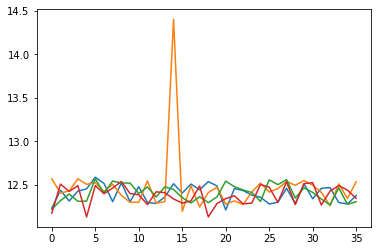

In [14]:
plt.figure()
for i in timing_coap_ltem:
    plt.plot(np.array(i))

36
36
36
36


Text(0.5, 0, 'Payload size [Bytes]')

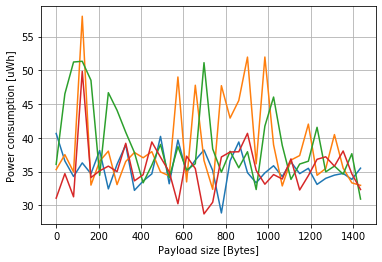

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#coap_ltem_sums = np.zeros((len(segments_coap_ltem[0]), len(segments_coap_ltem)))
coap_ltem_sums = []

for i in segments_coap_ltem:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - ltem_active_energy
        sum_acc.append(curr_sum)
        #coap_ltem_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_coap,sum_acc, label = str(idx_seg))
    coap_ltem_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [16]:
coap_ltem_stds = []
coap_ltem_avg = []


for i in range(len(coap_ltem_sums[0])):
    curr_sample = []
    for j in range(len(coap_ltem_sums)):
        curr_sample.append(coap_ltem_sums[j][i])
    coap_ltem_avg.append(np.mean(curr_sample))
    coap_ltem_stds.append(np.std(curr_sample))
   
print(np.mean(coap_ltem_stds))
print(coap_ltem_avg[1])

3.543053766725576
38.817989062815954


In [17]:
segments_mqtt_nb = []
timing_mqtt_nb = []

[segments_mqtt_nb, timing_mqtt_nb] = segment_data(mqtt_nb_current, 180000, 0.01, 140000, 20000)


Batch: 0
Batch: 1
Batch: 2


64
64
64


Text(0.5, 0, 'Payload size [Bytes]')

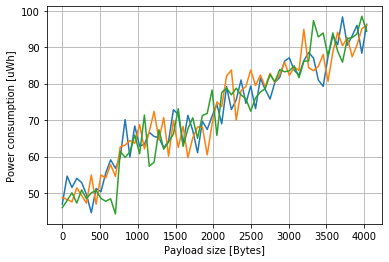

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#mqtt_nb_sums = np.zeros((len(segments_mqtt_nb[0]), len(segments_mqtt_nb)))

mqtt_nb_sums = []
bytes_mqtt = range(0,mqtt_byte_step*len(segments_mqtt_nb[0]), mqtt_byte_step)

for i in segments_mqtt_nb:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - nb_active_energy
        sum_acc.append(curr_sum)
        #mqtt_nb_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_mqtt,sum_acc, label = str(idx_seg))
    mqtt_nb_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [19]:
mqtt_nb_stds = []
mqtt_nb_avg = []

for i in range(len(mqtt_nb_sums[0])):
    curr_sample = []
    for j in range(len(mqtt_nb_sums)):
        curr_sample.append(mqtt_nb_sums[j][i])
    mqtt_nb_avg.append(np.mean(curr_sample))
    mqtt_nb_stds.append(np.std(curr_sample))
   
print(np.mean(mqtt_nb_stds))
print(mqtt_nb_avg[1])
print(len(mqtt_nb_avg))

2.860867183651253
50.26023414758796
64


In [20]:
segments_mqtt_ltem = []
timing_mqtt_ltem = []

[segments_mqtt_ltem, timing_mqtt_ltem] = segment_data(mqtt_ltem_current, 120000, 0.01, 100000, 20000)


Batch: 0
Batch: 1


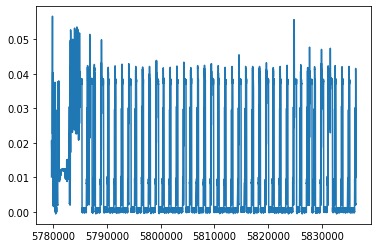

In [21]:
segments_mqtt_ltem[0][47].plot()

64
64


Text(0.5, 0, 'Payload size [Bytes]')

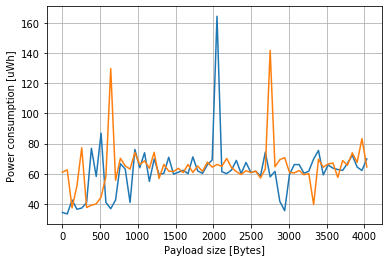

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx_seg = 0

#mqtt_ltem_sums = np.zeros((len(segments_mqtt_ltem[0]), len(segments_mqtt_ltem)))
mqtt_ltem_sums = []
bytes_mqtt = range(0,mqtt_byte_step*len(segments_mqtt_ltem[0]), mqtt_byte_step)

for i in segments_mqtt_ltem:
    sum_acc = []
    idx_sample = 0
    for j in i:
        curr_sum = j.sum()*to_uWh - ltem_active_energy
        sum_acc.append(curr_sum)
        #mqtt_ltem_sums[idx_sample][idx_seg] = curr_sum
        idx_sample += 1
    
    print(np.size(sum_acc))
    plt.plot(bytes_mqtt,sum_acc, label = str(idx_seg))
    mqtt_ltem_sums.append(sum_acc)
    idx_seg += 1

#for i in range(len(bytes_coap)):
#    ax.annotate('(%d)' % (bytes_coap[i]), xy=(i*coap_byte_step,sum_acc[i]))

    
plt.grid()
    
plt.ylabel("Power consumption [uWh]")
plt.xlabel("Payload size [Bytes]")

In [23]:
mqtt_ltem_stds = []
mqtt_ltem_avg = []

for i in range(len(mqtt_ltem_sums[0])):
    curr_sample = []
    for j in range(len(mqtt_ltem_sums)):
        curr_sample.append(mqtt_ltem_sums[j][i])

    mqtt_ltem_avg.append(np.mean(curr_sample))
    mqtt_ltem_stds.append(np.std(curr_sample))
   
print(np.mean(mqtt_ltem_stds))
print(mqtt_ltem_avg[1])
print(len(mqtt_ltem_avg))

6.524353720767529
47.96039843950696
64


In [24]:
coap_ltem_smooth = sig.savgol_filter(coap_ltem_avg,9,3)
coap_nb_smooth = sig.savgol_filter(coap_nb_avg,9,3)
mqtt_nb_smooth = sig.savgol_filter(mqtt_nb_avg,9,3)
mqtt_ltem_smooth = sig.savgol_filter(mqtt_ltem_avg,9,3)

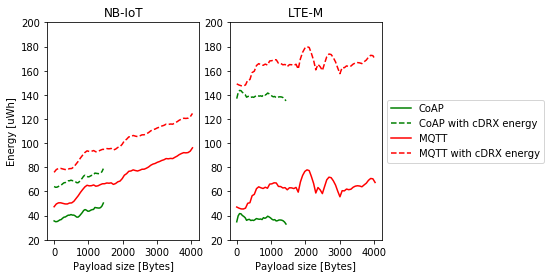

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('NB-IoT')
ax2.set_title('LTE-M')

ax1.set(ylabel="Energy [uWh]")
ax1.set_xlabel("Payload size [Bytes]")
ax2.set_xlabel("Payload size [Bytes]")
ax1.set_ylim([20,200])
ax2.set_ylim([20,200])

#plt.plot(bytes_coap, coap_nb_avg   ,     label = "CoAP NB-IoT average")
ax1.plot(bytes_coap, coap_nb_smooth, "g" ,label = "NB-IoT")
ax1.plot(bytes_coap, coap_nb_smooth+nb_active_energy, "g--" ,label = "NB-IoT")


#plt.plot(bytes_mqtt, mqtt_nb_avg   ,       label = "MQTT 2300 average")
ax1.plot(bytes_mqtt, mqtt_nb_smooth, "r" ,label = "NB-IoT")
ax1.plot(bytes_mqtt, mqtt_nb_smooth+nb_active_energy, "r--" ,label = "NB-IoT")


#plt.plot(bytes_coap, coap_ltem_avg   ,     label = "CoAP LTE-M average")
ax2.plot(bytes_coap, coap_ltem_smooth, "g", label = "CoAP")
ax2.plot(bytes_coap, coap_ltem_smooth+ltem_active_energy, "g--", label = "CoAP with cDRX energy")


#plt.plot(bytes_mqtt, mqtt_ltem_avg   ,       label = "MQTT 2300 average")
ax2.plot(bytes_mqtt, mqtt_ltem_smooth, "r" ,label = "MQTT")
ax2.plot(bytes_mqtt, mqtt_ltem_smooth+ltem_active_energy, "r--" ,label = "MQTT with cDRX energy")

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [26]:
print("## NB Time")
timing_coap_nb_res = do_linear_regression(bytes_coap, timing_coap_nb)
timing_mqtt_nb_res = do_linear_regression(bytes_mqtt, timing_mqtt_nb)
print("## LTE-M Time")
timing_coap_ltem_res = do_linear_regression(bytes_coap, timing_coap_ltem)
timing_mqtt_ltem_res = do_linear_regression(bytes_mqtt, timing_mqtt_ltem)

print("## NB energy")
energy_mqtt_nb_res = do_linear_regression(bytes_mqtt, mqtt_nb_sums)
energy_coap_nb_res = do_linear_regression(bytes_coap, coap_nb_sums)

print("## LTE-M energy")
energy_mqtt_ltem_res = do_linear_regression(bytes_mqtt, mqtt_ltem_sums)
energy_coap_ltem_res = do_linear_regression(bytes_coap, coap_ltem_sums)

result_matrix = {
    'timing_coap_nb'   : [timing_coap_nb_res[0][0]  , timing_coap_nb_res[1]],
    'energy_coap_nb'   : [energy_coap_nb_res[0][0]  , energy_coap_nb_res[1]],
    'timing_coap_ltem' : [timing_coap_ltem_res[0][0], timing_coap_ltem_res[1]],
    'energy_coap_ltem' : [energy_coap_ltem_res[0][0], energy_coap_ltem_res[1]],
    'timing_mqtt_nb'   : [timing_mqtt_nb_res[0][0]  , timing_mqtt_nb_res[1]],
    'energy_mqtt_nb'   : [energy_mqtt_nb_res[0][0]  , energy_mqtt_nb_res[1]],
    'timing_mqtt_ltem' : [timing_mqtt_ltem_res[0][0], timing_mqtt_ltem_res[1]],
    'energy_mqtt_ltem' : [energy_mqtt_ltem_res[0][0], energy_mqtt_ltem_res[1]]
}

regression_results = pd.DataFrame(data = result_matrix)


## NB Time
Accuracy: -1.13 (+/- 1.43)
Mean Squared Error: 2.3288136478632846
Accuracy: -3.08 (+/- 1.45)
Mean Squared Error: 3.4484089588409454
## LTE-M Time
Accuracy: -0.04 (+/- 0.16)
Mean Squared Error: 0.010340760817711438
Accuracy: -2.53 (+/- 5.75)
Mean Squared Error: 0.6476755309669182
## NB energy
Accuracy: -18.75 (+/- 17.73)
Mean Squared Error: 17.37781250544843
Accuracy: -8.30 (+/- 5.73)
Mean Squared Error: 6.822813566567768
## LTE-M energy
Accuracy: -277.93 (+/- 556.61)
Mean Squared Error: 80.02951693830354
Accuracy: -24.92 (+/- 34.81)
Mean Squared Error: 47.88011824695386


In [27]:
regression_results.to_csv("reg_res.csv")

In [28]:
regression_results

,timing_coap_nb,energy_coap_nb,timing_coap_ltem,energy_coap_ltem,timing_mqtt_nb,energy_mqtt_nb,timing_mqtt_ltem,energy_mqtt_ltem
0,0.000381,0.008741,-0.000004,-0.002645,0.000493,0.011474,0.000199,0.002831
1,27.493343,35.500090,12.413665,39.054796,28.637847,48.912151,13.957278,57.836425


Energy consumption intersection at: 312.18202078246117


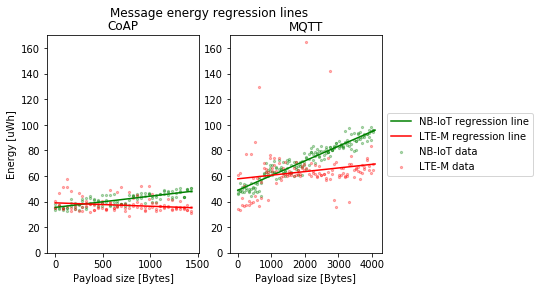

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2)

fig.suptitle("Message energy regression lines")
x_mqtt = np.linspace(0,4096,4096)
x_coap = np.linspace(0,1439,1439)

## CoAP
ax1.set_title("CoAP")
ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Payload size [Bytes]")
ax1.set_ylim([0,170])

y_coap_nb = energy_coap_nb_res[0]*x_coap+energy_coap_nb_res[1]
y_coap_ltem = energy_coap_ltem_res[0]*x_coap+energy_coap_ltem_res[1]

ax1.plot(x_coap,y_coap_nb,    "g", label="NB-IoT regression line")
ax1.scatter(bytes_coap, coap_nb_sums[0], color = "g", s=5, alpha=0.3, label="NB-IoT data")
ax1.scatter(bytes_coap, coap_nb_sums[1], color = "g", s=5, alpha=0.3)   
ax1.scatter(bytes_coap, coap_nb_sums[2], color = "g", s=5, alpha=0.3)   

ax1.plot(x_coap,y_coap_ltem,  "r", label="LTE-M regression line")
ax1.scatter(bytes_coap, coap_ltem_sums[0], color = "r", s=5, alpha=0.3, label="LTE-M data")
ax1.scatter(bytes_coap, coap_ltem_sums[1], color = "r", s=5, alpha=0.3)   
ax1.scatter(bytes_coap, coap_ltem_sums[2], color = "r", s=5, alpha=0.3)   

## MQTT
ax2.set_title("MQTT")
ax2.set_xlabel("Payload size [Bytes]")
ax2.set_ylim([0,170])


y_mqtt_nb   = energy_mqtt_nb_res[0]  * x_mqtt+energy_mqtt_nb_res[1]
y_mqtt_ltem = energy_mqtt_ltem_res[0]* x_mqtt+energy_mqtt_ltem_res[1]

ax2.plot(x_mqtt,y_mqtt_nb,    "g", label="NB-IoT regression line")
ax2.scatter(bytes_mqtt, mqtt_nb_sums[0], color = "g", s=5, alpha=0.3, label="NB-IoT data")
ax2.scatter(bytes_mqtt, mqtt_nb_sums[1], color = "g", s=5, alpha=0.3)   
ax2.scatter(bytes_mqtt, mqtt_nb_sums[2], color = "g", s=5, alpha=0.3)   

ax2.plot(x_mqtt,y_mqtt_ltem,  "r", label="LTE-M regression line")
ax2.scatter(bytes_mqtt, mqtt_ltem_sums[0], color = "r", s=5, alpha=0.3, label="LTE-M data")
ax2.scatter(bytes_mqtt, mqtt_ltem_sums[1], color = "r", s=5, alpha=0.3)   
#ax2.scatter(bytes_mqtt, mqtt_ltem_sums[2], color = "r", s=5, alpha=0.3)   



ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("plots/energy_reg_lines.pdf", bbox_inches='tight')

intersect = (energy_coap_nb_res[1]-energy_coap_ltem_res[1])/(energy_coap_ltem_res[0][0]-energy_coap_nb_res[0][0])
print("Energy consumption intersection at: " + str(intersect))

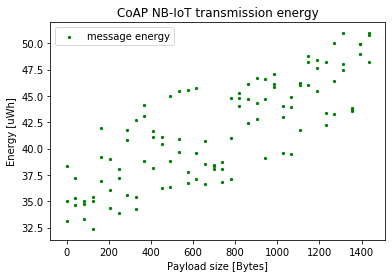

In [45]:
plt.title("CoAP NB-IoT transmission energy")

plt.ylabel("Energy [uWh]")
plt.xlabel("Payload size [Bytes]")

plt.scatter(bytes_coap, coap_nb_sums[0], color = "g", s=5, label="message energy")
plt.scatter(bytes_coap, coap_nb_sums[1], color = "g", s=5)   
plt.scatter(bytes_coap, coap_nb_sums[2], color = "g", s=5)   

plt.legend()

plt.savefig("../dt_thesis/plots/energy_coap_demo.pdf", bbox_inches='tight')

No handles with labels found to put in legend.


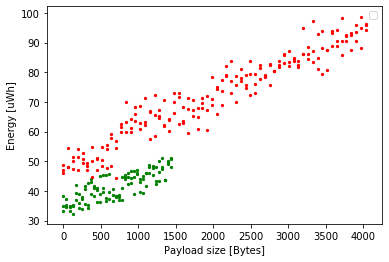

In [61]:

plt.ylabel("Energy [uWh]")
plt.xlabel("Payload size [Bytes]")

xMax = 4096
yMin = 30
yMax = 110

#plt.(yMin,yMax)


plt.scatter(bytes_coap, coap_nb_sums[0], color = "g", s=5)
plt.scatter(bytes_coap, coap_nb_sums[1], color = "g", s=5)   
plt.scatter(bytes_coap, coap_nb_sums[2], color = "g", s=5) 
#ax2.scatter(bytes_coap, coap_ltem_sums[0], color = "g", s=5)
#ax2.scatter(bytes_coap, coap_ltem_sums[1], color = "g", s=5)   
#ax2.scatter(bytes_coap, coap_ltem_sums[2], color = "g", s=5) 


plt.scatter(bytes_mqtt, mqtt_nb_sums[0], color = "r", s=5)
plt.scatter(bytes_mqtt, mqtt_nb_sums[1], color = "r", s=5)   
plt.scatter(bytes_mqtt, mqtt_nb_sums[2], color = "r", s=5) 


plt.legend()

plt.savefig("../dt_thesis/plots/energy_coap_demo.pdf", bbox_inches='tight')

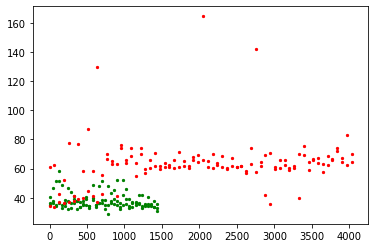

In [55]:

#ax1.scatter(bytes_mqtt, mqtt_nb_sums[0], color = "g", s=5)
#ax1.scatter(bytes_mqtt, mqtt_nb_sums[1], color = "g", s=5)   
#ax1.scatter(bytes_mqtt, mqtt_nb_sums[2], color = "g", s=5) 

plt.scatter(bytes_coap, coap_ltem_sums[0], color = "g", s=5)
plt.scatter(bytes_coap, coap_ltem_sums[1], color = "g", s=5)   
plt.scatter(bytes_coap, coap_ltem_sums[2], color = "g", s=5) 

plt.scatter(bytes_mqtt, mqtt_ltem_sums[0], color = "r", s=5)
plt.scatter(bytes_mqtt, mqtt_ltem_sums[1], color = "r", s=5)   
#ax4.scatter(bytes_mqtt, mqtt_ltem_sums[2], color = "g", s=5) 

Energy consumption intersection at: 1032.5297856605468


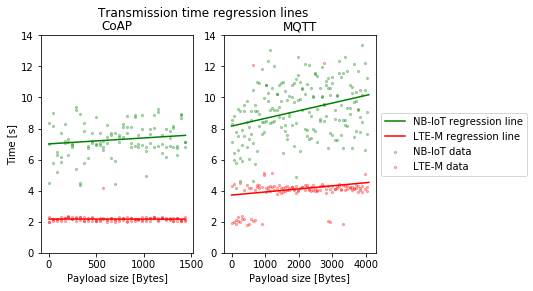

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2)

fig.suptitle("Transmission time regression lines")
x_mqtt = np.linspace(0,4096,4096)
x_coap = np.linspace(0,1439,1439)

y_min_t = 0
y_max_t = 14

ax1.set_ylim([y_min_t,y_max_t])
ax2.set_ylim([y_min_t,y_max_t])


## CoAP
ax1.set_title("CoAP")
ax1.set_ylabel("Time [s]")
ax1.set_xlabel("Payload size [Bytes]")

y_coap_nb_t =   timing_coap_nb_res[0]  *x_coap+timing_coap_nb_res[1]
y_coap_ltem_t = timing_coap_ltem_res[0]*x_coap+timing_coap_ltem_res[1]

ax1.plot(x_coap,y_coap_nb_t-20.48, "g", label="NB-IoT regression line")
ax1.scatter(bytes_coap, np.array(timing_coap_nb[0])-20.48, color = "g", s=5, alpha=0.3, label="NB-IoT data")
ax1.scatter(bytes_coap, np.array(timing_coap_nb[1])-20.48, color = "g", s=5, alpha=0.3)   
ax1.scatter(bytes_coap, np.array(timing_coap_nb[2])-20.48, color = "g", s=5, alpha=0.3) 

ax1.plot(x_coap,y_coap_ltem_t-10.24, "r", label="LTE-M regression line") #subtracting the RRC Connected time of LTE-M. This is not consistent though 
ax1.scatter(bytes_coap, np.array(timing_coap_ltem[0])-10.24, color = "r", s=5, alpha=0.3, label="LTE-M data")
ax1.scatter(bytes_coap, np.array(timing_coap_ltem[1])-10.24, color = "r", s=5, alpha=0.3)   
ax1.scatter(bytes_coap, np.array(timing_coap_ltem[2])-10.24, color = "r", s=5, alpha=0.3)  

## MQTT
ax2.set_title("MQTT")
ax2.set_xlabel("Payload size [Bytes]")

y_mqtt_nb_t =   timing_mqtt_nb_res[0]  *x_mqtt+timing_mqtt_nb_res[1]
y_mqtt_ltem_t = timing_mqtt_ltem_res[0]*x_mqtt+timing_mqtt_ltem_res[1]

ax2.plot(x_mqtt,y_mqtt_nb_t-20.48, "g", label="NB-IoT regression line")
ax2.scatter(bytes_mqtt, np.array(timing_mqtt_nb[0])-20.48, color = "g", s=5, alpha=0.3, label="NB-IoT data")
ax2.scatter(bytes_mqtt, np.array(timing_mqtt_nb[1])-20.48, color = "g", s=5, alpha=0.3)   
ax2.scatter(bytes_mqtt, np.array(timing_mqtt_nb[2])-20.48, color = "g", s=5, alpha=0.3) 

ax2.plot(x_mqtt,y_mqtt_ltem_t-10.24, "r", label="LTE-M regression line") #subtracting the RRC Connected time of LTE-M. This is not consistent though 
ax2.scatter(bytes_mqtt, np.array(timing_mqtt_ltem[0])-10.24, color = "r", s=5, alpha=0.3, label="LTE-M data")
ax2.scatter(bytes_mqtt, np.array(timing_mqtt_ltem[1])-10.24, color = "r", s=5, alpha=0.3)   
#ax2.scatter(bytes_mqtt, np.array(timing_mqtt_ltem[2])*delta_t-10.24, color = "r", s=5, alpha=0.3)  

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("plots/time_reg_lines.pdf", bbox_inches='tight')


intersect = (energy_mqtt_nb_res[1]-energy_mqtt_ltem_res[1])/(energy_mqtt_ltem_res[0][0]-energy_mqtt_nb_res[0][0])
print("Energy consumption intersection at: " + str(intersect))

In [32]:
residuals_coap_nb   = get_residuals(coap_nb_sums,   energy_coap_nb_res,     bytes_coap)
residuals_coap_ltem = get_residuals(coap_ltem_sums, energy_coap_ltem_res,   bytes_coap)
residuals_mqtt_nb   = get_residuals(mqtt_nb_sums,   energy_mqtt_nb_res,     bytes_mqtt)
residuals_mqtt_ltem = get_residuals(mqtt_ltem_sums, energy_mqtt_ltem_res,   bytes_mqtt)

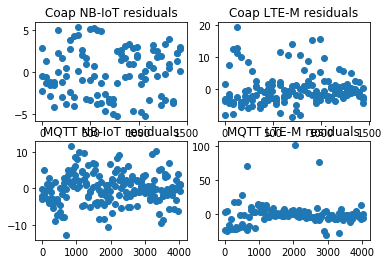

In [33]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

ax1.set_title("Coap NB-IoT residuals")
ax2.set_title("Coap LTE-M residuals")
ax3.set_title("MQTT NB-IoT residuals")
ax4.set_title("MQTT LTE-M residuals")


ax1.scatter(residuals_coap_nb[0],   residuals_coap_nb[1])
ax2.scatter(residuals_coap_ltem[0], residuals_coap_ltem[1])
ax3.scatter(residuals_mqtt_nb[0],   residuals_mqtt_nb[1])
ax4.scatter(residuals_mqtt_ltem[0], residuals_mqtt_ltem[1])


Text(0.5, 1.0, 'MQTT LTE-M')

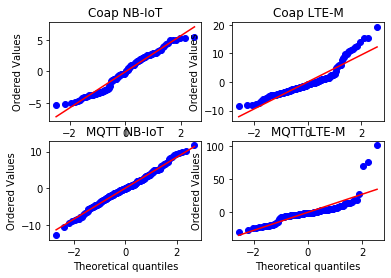

In [34]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

res1 = stat.probplot(residuals_coap_nb[1], plot=ax1)
res2 = stat.probplot(residuals_coap_ltem[1], plot=ax2)
res3 = stat.probplot(residuals_mqtt_nb[1], plot=ax3)
res4 = stat.probplot(residuals_mqtt_ltem[1], plot=ax4)

ax1.set_title("Coap NB-IoT")
ax2.set_title("Coap LTE-M")
ax3.set_title("MQTT NB-IoT")
ax4.set_title("MQTT LTE-M")

#print(normalized)

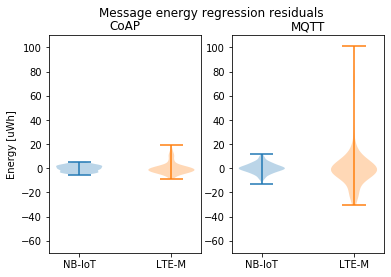

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle("Message energy regression residuals")

ax1.set(ylabel="Energy [uWh]")
y_min = -70
y_max = 110

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

ax1.set_title("CoAP")
ax1.set_xticks([1,2])
ax1.set_xticklabels(['NB-IoT', "LTE-M"])
ax2.set_title("MQTT")
ax2.set_xticks([1,2])
ax2.set_xticklabels(['NB-IoT', "LTE-M"])

ax1.violinplot(residuals_coap_nb[1], positions = [1])
ax1.violinplot(residuals_coap_ltem[1], positions = [2])

ax2.violinplot(residuals_mqtt_nb[1], positions = [1])
ax2.violinplot(residuals_mqtt_ltem[1], positions = [2])

plt.savefig("plots/energy_reg_res.pdf", bbox_inches='tight')


In [36]:
residuals_time_coap_nb   = get_residuals(timing_coap_nb,   timing_coap_nb_res,     bytes_coap)
residuals_time_coap_ltem = get_residuals(timing_coap_ltem, timing_coap_ltem_res,   bytes_coap)
residuals_time_mqtt_nb   = get_residuals(timing_mqtt_nb,   timing_mqtt_nb_res,     bytes_mqtt)
residuals_time_mqtt_ltem = get_residuals(timing_mqtt_ltem, timing_mqtt_ltem_res,   bytes_mqtt)

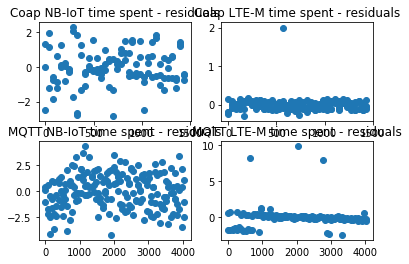

In [37]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)

ax1.set_title("Coap NB-IoT time spent - residuals")
ax2.set_title("Coap LTE-M time spent - residuals")
ax3.set_title("MQTT NB-IoT time spent - residuals")
ax4.set_title("MQTT LTE-M time spent - residuals")

ax1.scatter(residuals_time_coap_nb[0]  , residuals_time_coap_nb[1])
ax2.scatter(residuals_time_coap_ltem[0], residuals_time_coap_ltem[1])
ax3.scatter(residuals_time_mqtt_nb[0]  , residuals_time_mqtt_nb[1]    )
ax4.scatter(residuals_time_mqtt_ltem[0], residuals_time_mqtt_ltem[1])


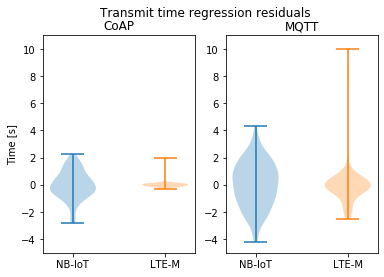

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle("Transmit time regression residuals")

ax1.set(ylabel="Time [s]")
y_min = -5
y_max = 11

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

ax1.set_title("CoAP")
ax1.set_xticks([1,2])
ax1.set_xticklabels(['NB-IoT', "LTE-M"])
ax2.set_title("MQTT")
ax2.set_xticks([1,2])
ax2.set_xticklabels(['NB-IoT', "LTE-M"])

ax1.violinplot(residuals_time_coap_nb[1]  , positions = [1])
ax1.violinplot(residuals_time_coap_ltem[1], positions = [2])

ax2.violinplot(residuals_time_mqtt_nb[1]  , positions = [1])
ax2.violinplot(residuals_time_mqtt_ltem[1], positions = [2])

plt.savefig("plots/time_reg_res.pdf", bbox_inches='tight')

